In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.7 MB/s eta 0:00:00


## Packages

In [13]:
import re
import string

import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
from spacy.lang.pt.stop_words import STOP_WORDS

## Read Dataset

In [5]:
songs = pd.read_csv("drive/MyDrive/Colab Notebooks/dataset/input/songs.csv", sep=";")

## Filter Brazilian Songs

In [8]:
songs = songs.query('is_pt != "Tradução " and category != "Fado"')

## Data transformation

In [14]:
nltk.download('stopwords', quiet=True)

True

### Transformation functions

In [17]:
CUSTOM_STOPWORDS = {'pra', 'pro', 'vou', 'deu', 'igual', 'mim'}

SINGLE_LETTER_REGEX = re.compile(r'\s+[a-zA-Z]\s+')
PUNCTUATION_REGEX = re.compile(f"[{re.escape(string.punctuation)}]")
WHITESPACE_REGEX = re.compile(r'\s+')

STOP_WORDS_SET = {
    unidecode(word).lower()
    for word in STOP_WORDS.union(stopwords.words('portuguese')).union(CUSTOM_STOPWORDS)
}

In [18]:
def clean_text(text: str) -> str:
    text = (
            text.replace('<div data-plugin="googleTranslate" id="lyrics">', '')
            .replace('</div>', '')
            .replace('<br/>', ' ')
            .replace('Am','')
            .replace('Em','')
            .replace('B7','')
        )
    text = unidecode(text).lower()
    text = PUNCTUATION_REGEX.sub("", text)
    text = WHITESPACE_REGEX.sub(" ", text)
    text = ''.join([c for c in text if not c.isdigit()])
    text = SINGLE_LETTER_REGEX.sub(" ", text)
    tokens = [word for word in text.split() if word not in STOP_WORDS_SET]
    return ' '.join(tokens)

In [30]:
def clean_just_tags(text: str) -> str:
    return (
            text.replace('<div data-plugin="googleTranslate" id="lyrics">', '')
            .replace('</div>', '')
            .replace('<br/>', ' ')
            .replace('Am','')
            .replace('Em','')
            .replace('B7','')
        )

In [38]:
def remove_duplicate_words(text: str) -> str:
  return ' '.join(dict.fromkeys(text.split()))

def add_text_length(text: str) -> int:
  return len(text)

In [40]:
def map_category(category: str) -> str:
    if category == 'Gospel/Religioso':
        return 'Religioso'
    elif category == 'Funk Carioca':
        return 'Funk'
    return category

### Clean text to analysis

In [19]:
songs["transformed"] = songs['lyrics'].apply(clean_text)

In [29]:
columns = ["lyrics", "transformed"]
songs[columns].head(1)

,lyrics,transformed
0,"<div data-plugin=""googleTranslate"" id=""lyrics""...",dirigir beba beber chame irmao saia rotina cai...


### Remove duplicate words to analysis

In [39]:
songs['reduce'] = songs['transformed'].apply(remove_duplicate_words)
songs['len'] = songs['reduce'].apply(add_text_length)

### Clean text to classifier

In [31]:
songs["transformed_without_tags"] = songs['lyrics'].apply(clean_just_tags)

In [36]:
columns = ["lyrics", "transformed_without_tags"]
songs[columns].head(1)

,lyrics,transformed_without_tags
0,"<div data-plugin=""googleTranslate"" id=""lyrics""...","Se dirigir, não beba! Mas se for beber, me cha..."


### Clean categories to classifier

In [41]:
songs['category'] = songs['category'].apply(map_category)

<Axes: ylabel='category'>

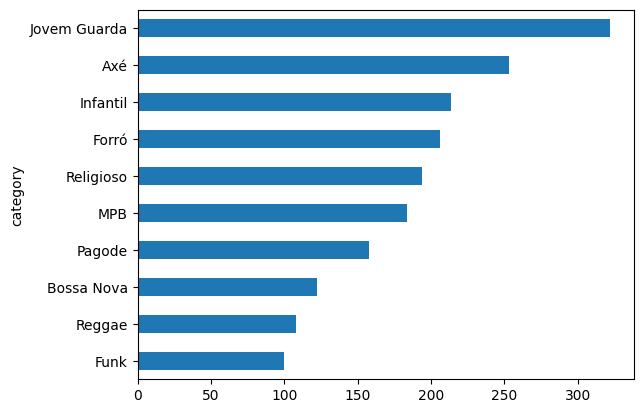

In [53]:
songs['category'].value_counts().head(10).sort_values(ascending=True).plot.barh()

### Filtering songs with more than 50 occurrences

In [56]:
songs = songs.groupby('category').filter(lambda x: len(x) >= 50)

### Save data

In [57]:
songs.to_csv("drive/MyDrive/Colab Notebooks/dataset/output/songs.csv", index=False, sep=";")

### Analysis

In [59]:
def generate_histograms(df: pd.DataFrame, output_path="histogram.png"):
    categories = df['category'].unique()
    fig = plt.figure(figsize=(10, 10))
    for i, category in enumerate(categories):
        ax = fig.add_subplot(5, 3, i + 1)
        df[df['category'] == category]['len'].hist(bins=10, ax=ax)
        ax.set_title(category)
    fig.tight_layout()
    plt.savefig(output_path)
    plt.show()

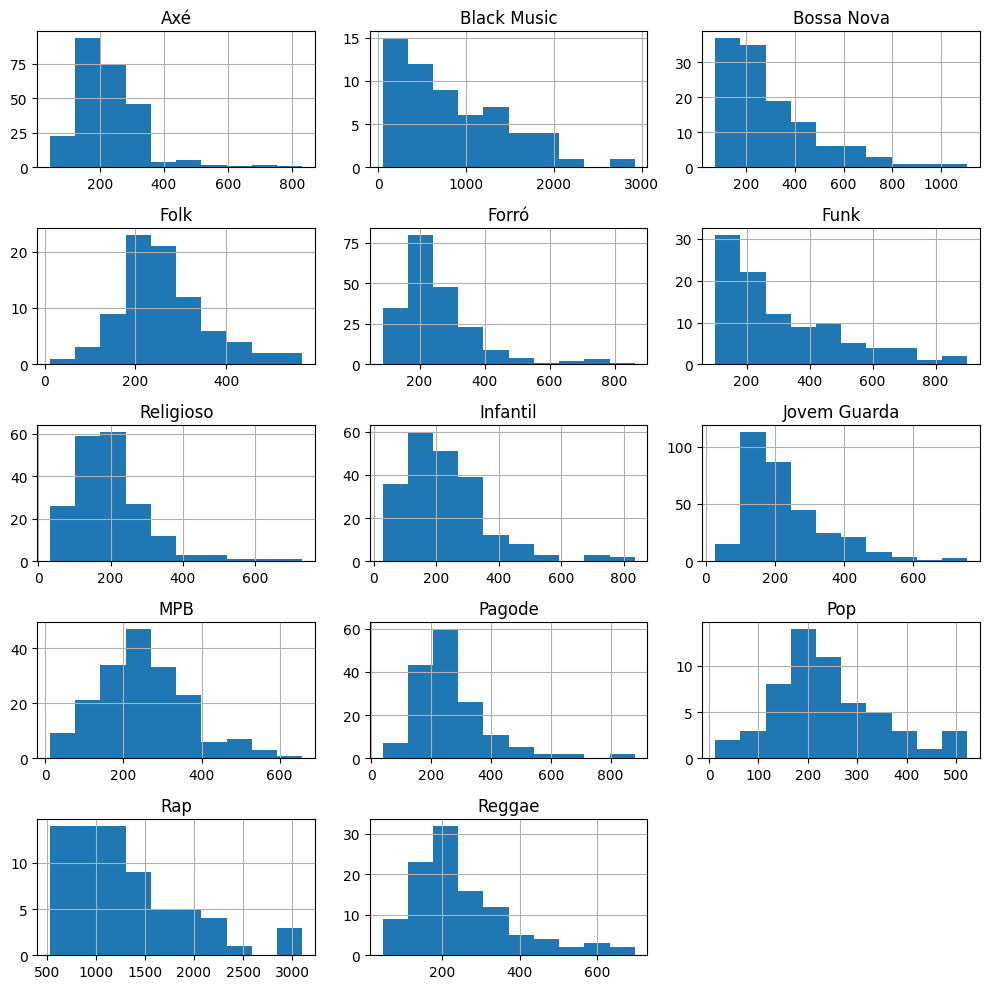

In [60]:
generate_histograms(songs)